# Porter Neural Network Regression

**Porter** is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.

Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.

This dataset has the required data to train a regression model that will do the delivery time estimation, based on all those features.

**Data Dictionary**

Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below.
1. market_id : integer id for the market where the restaurant lies
2. created_at : the timestamp at which the order was placed
3. actual_delivery_time : the timestamp when the order was delivered
4. store_primary_category : category for the restaurant
5. order_protocol : integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, pre booked, third part etc)
6. total_items subtotal : final price of the order
7. num_distinct_items : the number of distinct items in the order
8. min_item_price : price of the cheapest item in the order
9. max_item_price : price of the costliest item in order
10. total_onshift_partners : number of delivery partners on duty at the time order was placed
11. total_busy_partners : number of delivery partners attending to other tasks
12. total_outstanding_orders : total number of orders to be fulfilled at the moment

## Module 1 --- Building DataScientist MindSet

#### Before We Touch Any Code — Ask Questions First
This is the habit that separates seniors from **juniors**. A junior opens the dataset and starts coding. A **senior interrogates** the problem first.

#### The 5 Questions you always ask first
1. **What are we predicting and why does it matter?** We're predicting deliver time for porter(India's logistics platform). This matters because
- underestimating= Angry customers,
- OverEstimating = Losing business to competitors and > > Every Minute of error has real cost
2. **Who consumes this prediction? Is it dashboard for ops teams? A real-time API call when a customer places an order?**
- This changes how fast out model needs to be and how accurate it needs to be
3. **What does 'Good'/'success' look like?**
- In regression, accuracy means nothing. We need to error metric upfront.
4. **What data do we actually have and does it make logical sense**?
- Do the columns make intuitive sense for predicting delivery time? are there obvious things missing that should be there?
5. **What could go wrong/be misleading? DataLeakage? TimeBased issues? Biased collection? and so on...**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# load data 
data_path = "data//porter_dataset.csv"
original_df = pd.read_csv(data_path)

# create a copy of the original
df = original_df.copy(deep= True)
df.head() # top 5 rows

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [3]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")
print("---"*10)
print("Dtypes of all the features")
print(df.dtypes)
print("---"*10)
print("Columns list")
print(df.columns.tolist())

There are 197428 rows and 14 columns.
------------------------------
Dtypes of all the features
market_id                   float64
created_at                   object
actual_delivery_time         object
store_id                     object
store_primary_category       object
order_protocol              float64
total_items                   int64
subtotal                      int64
num_distinct_items            int64
min_item_price                int64
max_item_price                int64
total_onshift_partners      float64
total_busy_partners         float64
total_outstanding_orders    float64
dtype: object
------------------------------
Columns list
['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']


#### Immediate Observations
1. We have no target column.
- There's no delivery time minutes instead we have `created_at` and `actual_delivery_time` both in string type.
- So we have to create a target variable: `actual_deliver_time` - `created_at`.
2. Three float columns that should probably be integers.
`market_id`, `order_protocol`, `total_onshift_partners`, `total_busy_partners`, `total_outstanding_orders` are float64. Why? Because they have NaN values hiding in them. Pandas can't store NaN in an integer column, so it upcasts to float. This is a red flag for missing data.
3. `store_id` is a hash string. It's a categorical identifier with potentially hundreds of unique values. We need to check its cardinality before deciding how to handle it.

In [4]:
# Check missing values
print("Missing values:")
print(df.isnull().sum())
print("---"*10)

# Engineer the target variable
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['delivery_time_mins'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

print("---"*10)
print("Target variable stats:")
print(df['delivery_time_mins'].describe())
print("---"*10)

# Check store_id cardinality
print(f"Unique stores: {df['store_id'].nunique()}")
print(f"Unique markets: {df['market_id'].nunique()}")
print(f"Unique categories: {df['store_primary_category'].nunique()}")
print(f"Unique order protocols: {df['order_protocol'].nunique()}")

Missing values:
market_id                     987
created_at                      0
actual_delivery_time            7
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
dtype: int64
------------------------------
------------------------------
Target variable stats:
count    197421.000000
mean         48.470956
std         320.493482
min           1.683333
25%          35.066667
50%          44.333333
75%          56.350000
max      141947.650000
Name: delivery_time_mins, dtype: float64
------------------------------
Unique stores: 6743
Unique markets: 6
Unique categories: 74
Unique order protocols: 7


#### About the Target Variable
* The median is 44 minutes is perfectly reasonable for a food delivery. But a max of 98 days mean we have corrupt/erroneous records sitting in our data.
* 320 of std is alarm bell. In a healthy delivery dataset it should be 15-20 mins, 320 tells you extreme outliers are violently pulling it.
#### Missing Values - Read the pattern
don't Just See numbers, see why:
* `total_onshift_partners`, `total_busy_partners`, `total_outstanding_orders` — all missing 16,262 rows, exactly the same count. This is not random. These three columns are collected together from the same system, and that system failed or wasn't available for those orders. They'll need to be handled together.
* `market_id` and `order_protocol` missing ~1000 rows each — likely data entry or logging gaps. Small enough to potentially drop or impute.
* `store_primary_category missing` 4,760 rows — meaningful chunk. We can't just drop these, that's 2.4% of our data. We'll impute with a category like "unknown".
* `actual_delivery_time` missing 7 rows — we simply drop these since we can't build our target without them.

#### The Cardinality Insight
* 6,743 unique stores — this is too high to one-hot encode. We'll need target encoding or embedding. Keep this in mind for Module 5.
* 6 unique markets — low cardinality, easy to handle.
* 74 unique categories — medium, manageable.
* 7 order protocols — treat as categorical not numerical even though it's a number.

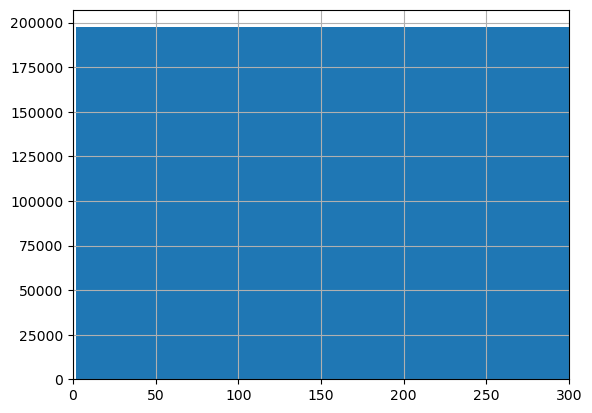

0.900     70.583333
0.950     81.200000
0.990    107.913333
0.999    165.581000
Name: delivery_time_mins, dtype: float64


In [5]:
df['delivery_time_mins'].hist(bins=100)
plt.xlim(0, 300)
plt.show()

print(df['delivery_time_mins'].quantile([0.90, 0.95, 0.99, 0.999]))

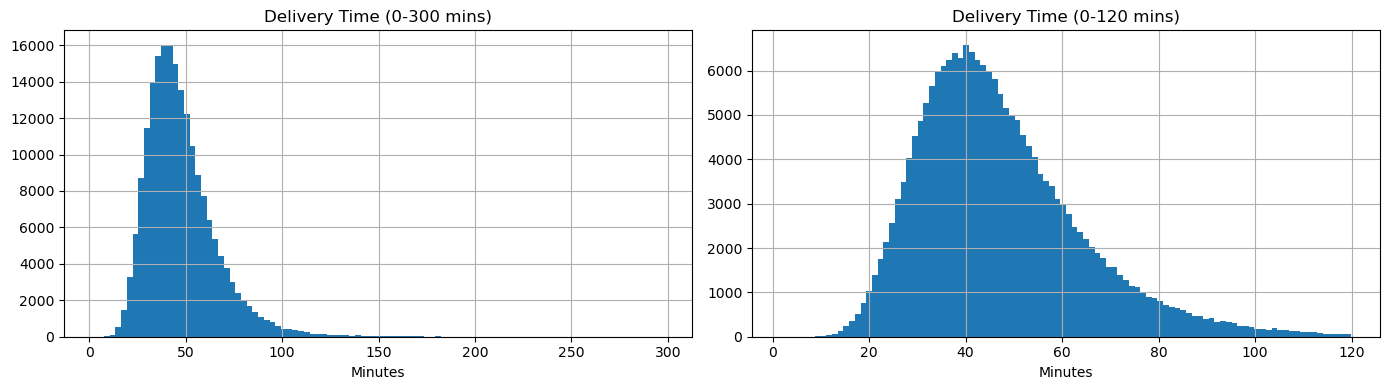

0.900     70.583333
0.950     81.200000
0.990    107.913333
0.999    165.581000
Name: delivery_time_mins, dtype: float64

How many orders exceed 120 mins: 1090
That is: 0.55% of data


In [6]:
# Filter to just the reasonable range first, then plot
clean = df[df['delivery_time_mins'] <= 300]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: zoomed in view
clean['delivery_time_mins'].hist(bins=100, ax=axes[0])
axes[0].set_title('Delivery Time (0-300 mins)')
axes[0].set_xlabel('Minutes')

# Right: just the bulk of data
bulk = df[df['delivery_time_mins'] <= 120]
bulk['delivery_time_mins'].hist(bins=100, ax=axes[1])
axes[1].set_title('Delivery Time (0-120 mins)')
axes[1].set_xlabel('Minutes')

plt.tight_layout()
plt.show()

# Quantiles
print(df['delivery_time_mins'].quantile([0.90, 0.95, 0.99, 0.999]))
print(f"\nHow many orders exceed 120 mins: {(df['delivery_time_mins'] > 120).sum()}")
print(f"That is: {(df['delivery_time_mins'] > 120).mean()*100:.2f}% of data")

In [7]:
# After filtering to 120 mins cutoff
df_clean = df[df['delivery_time_mins'] <= 120].copy()

skewness = df_clean['delivery_time_mins'].skew()
kurtosis = df_clean['delivery_time_mins'].kurtosis()

print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

# Now compare: original vs log transformed
log_target = np.log1p(df_clean['delivery_time_mins'])
print(f"\nLog transformed skewness: {log_target.skew():.4f}")
print(f"Log transformed kurtosis: {log_target.kurtosis():.4f}")

Skewness: 0.9808
Kurtosis: 1.2136

Log transformed skewness: -0.0314
Log transformed kurtosis: 0.0459


### Notes

**How does skewness in target variable effect the model, When we feed this target variable into a neural network, does it matter that it's skewed? Should we do anything about it, or just leave it as is?**

* The extreme values dominate the loss function. MSE/RMSE squares the errors.
* Skewness in target variable effects the model how it's going to train, because of few elements the model assumes high error and prioritize those errors which leads to unstabe gradient, poor generalization.
* They dominate the gradient updates and the model spends most of its learning energy trying to fit the rare extreme cases instead of the common ones. Your 40-minute deliveries get ignored in favor of the 110-minute outliers.

#### So Do We Transform?

Yes — and `log1p` is the go-to for delivery times. Here's why `log1p` over `log`:

```python
# log(0) = undefined, log1p(0) = log(1+0) = 0, safe for zeros
np.log1p(0)  # = 0, safe
np.log(0)    # = -inf, dangerous
```

**Critical rule:** Whatever transformation you apply to the target before training, you must **inverse transform** after prediction to get real minutes back.

```python
# Transform before training
y_transformed = np.log1p(y)

# Inverse after prediction
y_actual_minutes = np.expm1(y_predicted)
```

`expm1` is the exact inverse of `log1p`. You'll use this at inference time in deployment.

### Module 1 is Complete ✅

Here's what you've learned to do automatically now:

You asked the right business questions before touching data. You identified that the target had to be engineered from two datetime columns. You read missing value patterns and understood *why* they were missing, not just *that* they were missing. You caught a broken histogram and diagnosed why. You made a data-driven cutoff decision instead of a gut call. You identified skewness and knew the fix.

**That's a full senior checklist for first contact with a dataset.**

## Module 2 --- Exploratory Data Analysis

#### The Mindset for EDA
EDA is not about running a bunch of plots. It's about having a conversation with your data. Every chart should answer a question or raise a new one. We go in with hypothesis and let the data confirm or challenge them.

#### Our Hypothesis before we plot anything
Before running a  single line, let's think. What should affect delivery time?
1. More partners available -> Faster delivery (Supply side)
2. More outstanding orders -> Slower delivery (demand pressure)
3. Larger orders (more items) -> longer prep time -> slower delivery
4. Time of day matters -> lunch/dinner rush should be slower
5. Market matters - Some cities are biggest/bushier than others.

We'll use EDA to confirm or kill each hypothesis. This is how senior appraoch it.

In [8]:
## Step 1: Clean first, then explore
### we apply our 120 min cutoff so we're not analyzing garbage data.

# Apply cutoff and work on a clean copy
df_clean = df[df['delivery_time_mins'] <= 120].copy()
df_clean = df_clean[df_clean['delivery_time_mins'] > 0].copy()

print(f"Rows before: {len(df)}")
print(f"Rows after: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

Rows before: 197428
Rows after: 196331
Rows removed: 1097


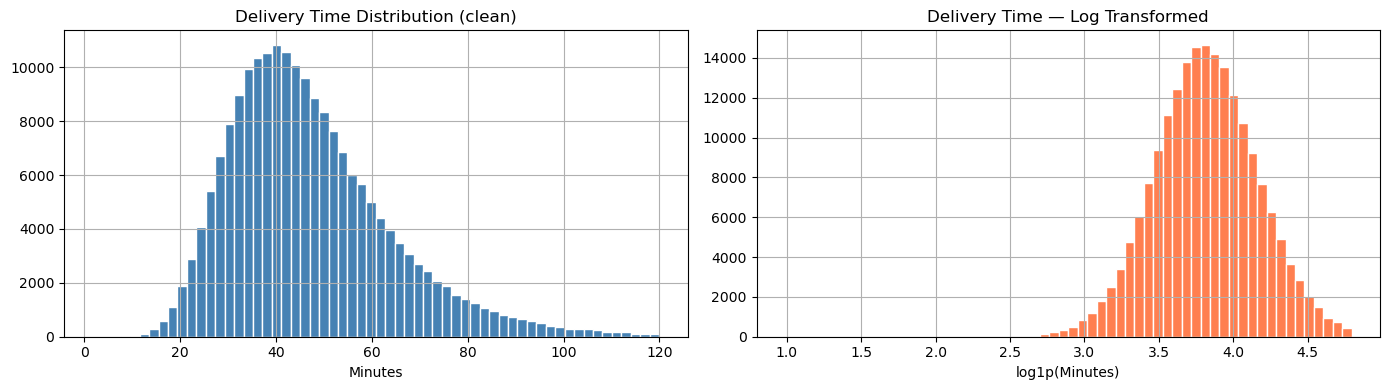

Skewness before log: 0.9808
Skewness after log:  -0.0314


In [9]:
## Step 2: Target Distribution 

fig, axes = plt.subplots(1, 2, figsize= (14, 4))

# Original scale
df_clean['delivery_time_mins'].hist(bins=60, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Delivery Time Distribution (clean)')
axes[0].set_xlabel('Minutes')

# Log transformed
np.log1p(df_clean['delivery_time_mins']).hist(bins=60, ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('Delivery Time — Log Transformed')
axes[1].set_xlabel('log1p(Minutes)')

plt.tight_layout()
plt.show()

# Skewness before and after
print(f"Skewness before log: {df_clean['delivery_time_mins'].skew():.4f}")
print(f"Skewness after log:  {np.log1p(df_clean['delivery_time_mins']).skew():.4f}")

#### Notes

Skewness of 0.98 means meaningfully right skewed. A skewness of **-0.03 is almost perfectly 0** — that's as close to normal as you'll ever get in real data.

The rule of thumb:
- Skewness between **-0.5 and 0.5** → fairly symmetric, fine as is
- Skewness between **0.5 and 1.0** → moderate skew, transformation recommended
- Skewness **above 1.0** → high skew, transformation strongly needed

At 0.98 we're right on the edge — and log brings it to -0.03. That's a massive improvement.

**What tricked your eye** is that the blue chart *looks* fairly normal visually. But looks can deceive — the numbers don't lie. That right tail from 60-120 mins is real skew even if it looks gentle.

##### The Decision

We **will** apply log1p to the target. The visual looked okay but the statistical measure says otherwise. This is exactly why we calculate skewness instead of just eyeballing — your eye will lie to you, the math won't.

> **Senior rule: When eye and statistics disagree, trust the statistics. Then go back and figure out why your eye was wrong.**

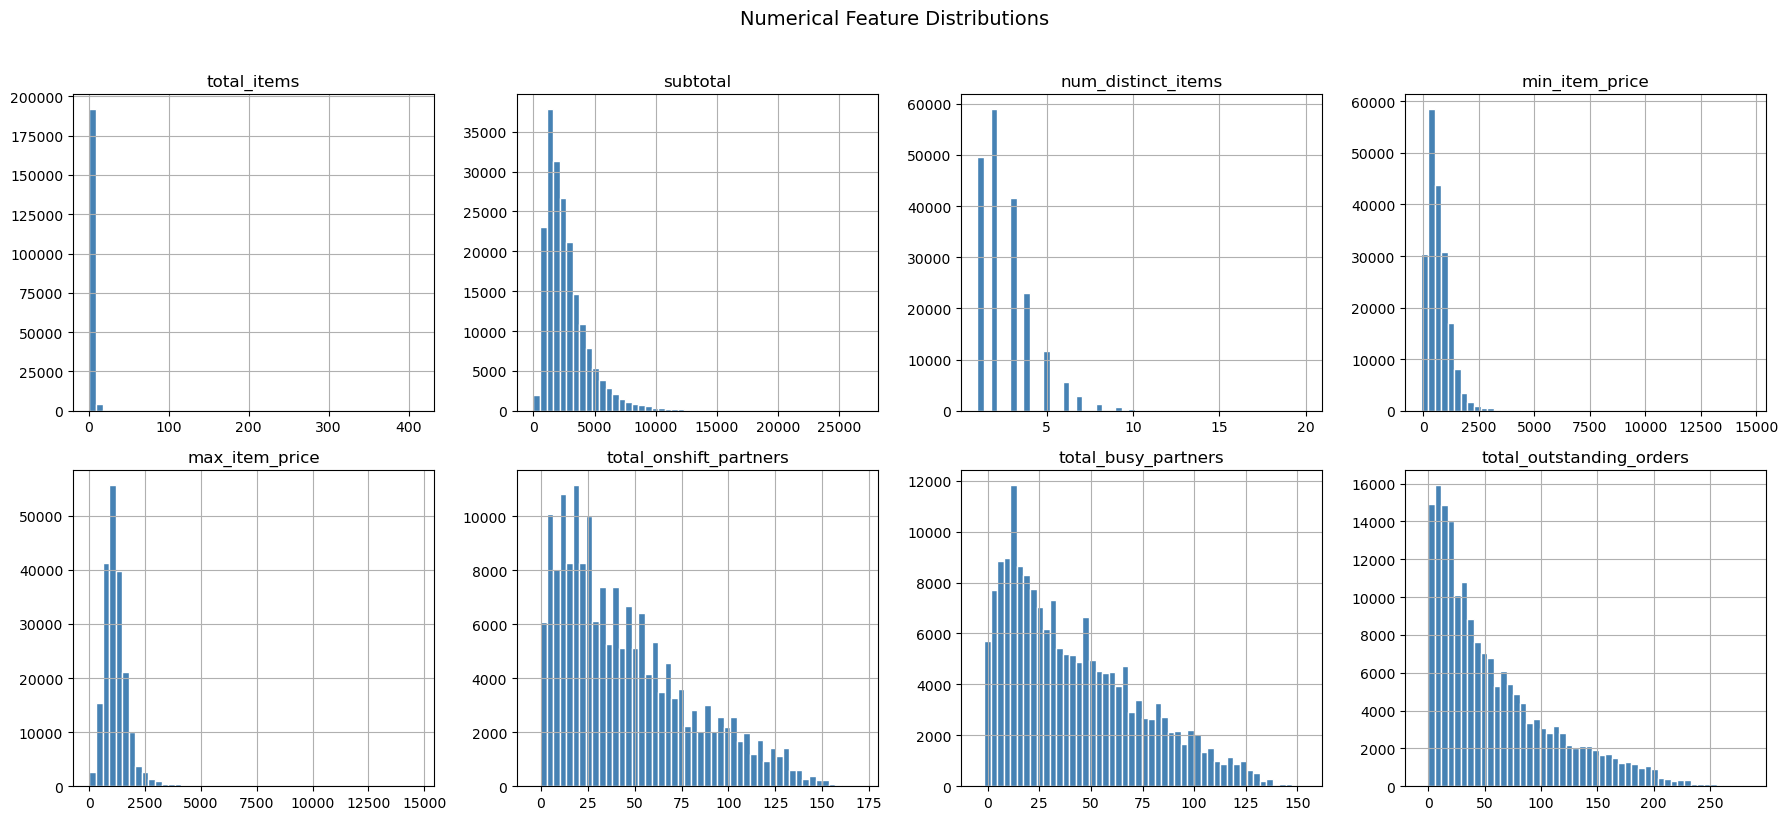

Skewness of each feature:
  total_items: 21.5513
  subtotal: 1.9550
  num_distinct_items: 1.5857
  min_item_price: 2.3211
  max_item_price: 2.1976
  total_onshift_partners: 0.8600
  total_busy_partners: 0.7816
  total_outstanding_orders: 1.1962


In [10]:
### Feature Analysis - Numerical features
numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 
                  'min_item_price', 'max_item_price', 
                  'total_onshift_partners', 'total_busy_partners', 
                  'total_outstanding_orders']

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df_clean[col].hist(bins=50, ax=axes[i], color='steelblue', edgecolor='white')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    
plt.suptitle('Numerical Feature Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Skewness for each
print("Skewness of each feature:")
for col in numerical_cols:
    print(f"  {col}: {df_clean[col].skew():.4f}")

#### Observation

Skewness of **21.55 is extreme.** That's not normal right skew — something suspicious is happening. Your value_counts investigation was the right instinct. Most orders are 1-5 items but there are entries going up to 400+ items. Those are almost certainly data errors or bulk/catering orders that don't represent normal food delivery behavior.

We'll need to cap this in cleaning.

#### Notes

##### Terminology Alert

You said "skewed toward left" and "left skewed." Look at the charts again — the long tail is dragging to the **right**. 

This is a common confusion so remember it this way:

> **The skew direction = where the tail points, not where the bulk is.**

- Bulk on left, tail on right = **Right skewed (positive skew)**
- Bulk on right, tail on left = **Left skewed (negative skew)**

All your features here are **right skewed** — confirmed by the positive skewness values (21.55, 1.95, etc.). Never mix this up in an interview or with a client.

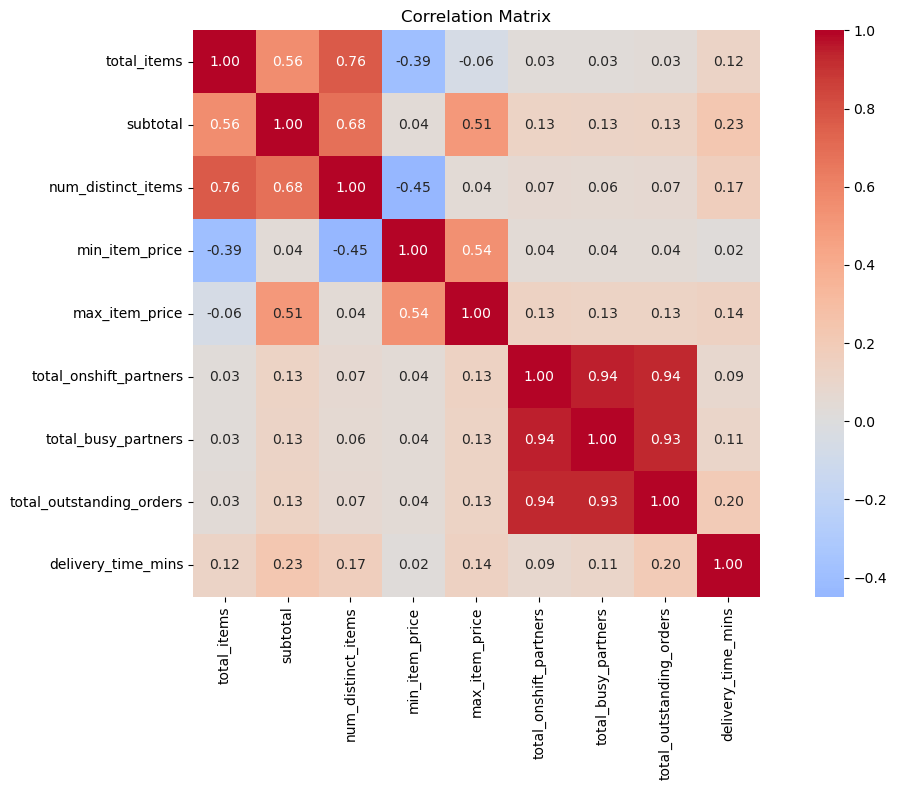

Correlation with delivery_time_mins:
delivery_time_mins          1.000000
subtotal                    0.228614
total_outstanding_orders    0.200424
num_distinct_items          0.165188
max_item_price              0.141719
total_items                 0.123625
total_busy_partners         0.107220
total_onshift_partners      0.086007
min_item_price              0.016667
Name: delivery_time_mins, dtype: float64


In [11]:
## Correlation with Target

# Correlation matrix with target
corr_cols = ['total_items', 'subtotal', 'num_distinct_items', 
             'min_item_price', 'max_item_price', 
             'total_onshift_partners', 'total_busy_partners', 
             'total_outstanding_orders', 'delivery_time_mins']

corr_matrix = df_clean[corr_cols].corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Just correlations with target, sorted
print("Correlation with delivery_time_mins:")
print(corr_matrix['delivery_time_mins'].sort_values(ascending=False))

#### The Elephant in the Room

Look at the bottom row. **Every single correlation with delivery_time_mins is weak** — the strongest is only 0.23.

This tells us two critical things:

**1. Linear relationships alone won't predict delivery time well.** This is actually *why* we need a neural network — the relationships are non-linear and complex. A weak Pearson correlation doesn't mean a feature is useless, it means the relationship isn't a straight line.

**2. Our most powerful features are probably the ones we haven't created yet** — the datetime features. Hour of day, day of week, these are hiding inside `created_at` right now.

---

#### Also Notice — Multicollinearity Confirmed

Look at the three partner/order features:


- onshift 
- busy 
- outstanding 

All three are **0.93-0.94 correlated with each other.** They're basically carrying the same information. For a linear model this would be a serious problem. For our neural network it's less critical but still worth noting — we may be able to engineer a single better feature from these three.

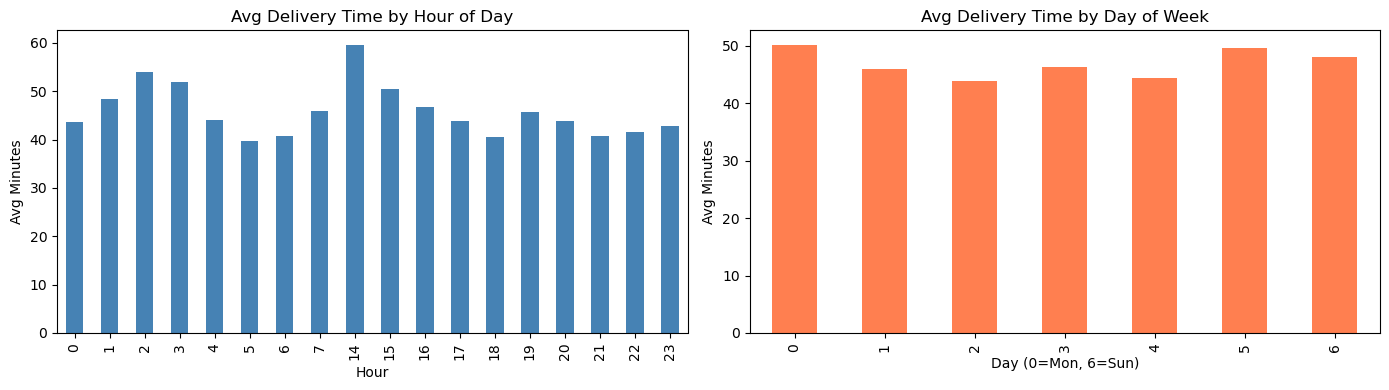

In [12]:
## Datetime EDA

# Extract datetime features
df_clean['hour'] = df_clean['created_at'].dt.hour
df_clean['day_of_week'] = df_clean['created_at'].dt.dayofweek  # 0=Monday, 6=Sunday

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Average delivery time by hour
df_clean.groupby('hour')['delivery_time_mins'].mean().plot(
    kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Avg Delivery Time by Hour of Day')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Avg Minutes')

# Average delivery time by day of week
df_clean.groupby('day_of_week')['delivery_time_mins'].mean().plot(
    kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Avg Delivery Time by Day of Week')
axes[1].set_xlabel('Day (0=Mon, 6=Sun)')
axes[1].set_ylabel('Avg Minutes')

plt.tight_layout()
plt.show()

#### Hour of Day - Partially Right, Partially Surprising

Your lunch hypothesis was confirmed — **hour 14 (2pm) is the peak at ~60 mins.** But breakfast (8-10am) and dinner (7-9pm) didn't show the spike you expected. The chart is actually quite noisy — hours 0-3am have *higher* delivery times than evening hours. Why?

Think about it — at 2am there are very few partners on shift. Low supply + even moderate demand = slow delivery. **It's not always about demand volume, it's about the supply-demand ratio.** This is a more nuanced insight than your original hypothesis.

The hour feature is clearly meaningful — delivery time swings from ~40 mins to ~60 mins across the day. **That 20 minute range is significant signal.**

#### Day of Week - The Data is Humbling Again

Your office days hypothesis was logical. But look at the chart — **all days are between 44-51 mins.** That's only a 7 minute spread across the entire week. Day of week has very weak signal for this dataset.

This is an important lesson:

> **A feature that makes logical sense doesn't always show up in the data. Log it, note it, but don't force it.**


#### EDA Summary - What We've Learned So Far

| Finding | Implication |
|---|---|
| Target right skewed (0.98) | Apply log1p before training |
| Max delivery time 98 days | Cap at 120 mins, remove 0.55% data |
| All features right skewed | Will need log/sqrt transformation in cleaning |
| Weak linear correlations (max 0.23) | Non-linear model justified — NN is right choice |
| Partner features 0.94 correlated | Multicollinearity — may engineer into one feature |
| total_items skewness 21.55 | Extreme outliers, needs capping |
| Hour of day shows ~20 min variation | Strong feature, must engineer from datetime |
| Day of week only 7 min variation | Weak feature, may drop |

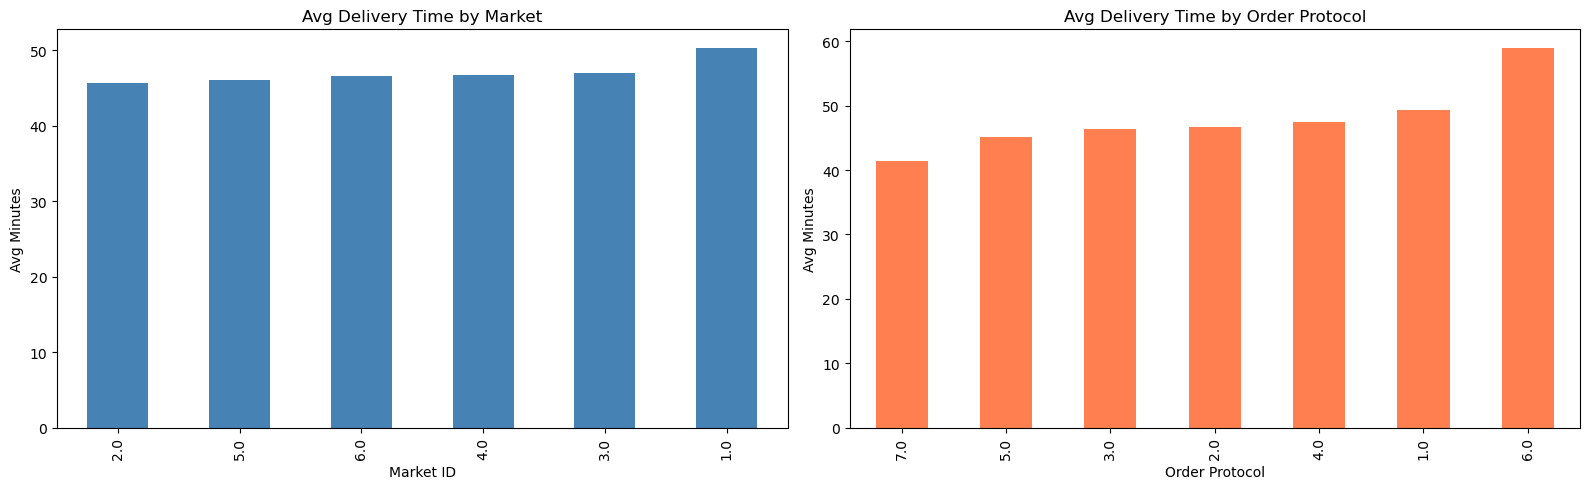

Top 10 slowest food categories:
store_primary_category
caribbean    55.580810
belgian      54.991667
spanish      54.390278
brazilian    54.383936
malaysian    52.290196
tapas        52.048592
cajun        52.047240
russian      51.507895
steak        51.272166
burmese      51.227989
Name: delivery_time_mins, dtype: float64


In [13]:
## EDA Categorical Features

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Market ID vs delivery time
df_clean.groupby('market_id')['delivery_time_mins'].mean().sort_values()\
    .plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Avg Delivery Time by Market')
axes[0].set_xlabel('Market ID')
axes[0].set_ylabel('Avg Minutes')

# Order protocol vs delivery time
df_clean.groupby('order_protocol')['delivery_time_mins'].mean().sort_values()\
    .plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Avg Delivery Time by Order Protocol')
axes[1].set_xlabel('Order Protocol')
axes[1].set_ylabel('Avg Minutes')

plt.tight_layout()
plt.show()

# Top 10 store categories by avg delivery time
print("Top 10 slowest food categories:")
print(df_clean.groupby('store_primary_category')['delivery_time_mins']\
      .mean().sort_values(ascending=False).head(10))

#### What the Data is Telling Us

**Market ID** — 4 minute spread, weak signal. May still keep it as a categorical feature since even small signals compound in a neural network, but we won't expect much from it.

**Order Protocol** — this is actually interesting. Protocol 6 averages ~59 mins vs Protocol 7 at ~41 mins. That's an **18 minute spread** — meaningful signal. Order protocol clearly affects how orders are routed/processed. Keep this.

**Food Categories** — Caribbean at 55 mins vs fast food probably around 38-40 mins. This makes complete intuitive sense. Caribbean, Belgian, Brazilian cuisine = complex preparation = longer delivery. **This is a genuinely useful feature.**


### EDA Complete wrt to Target✅

Here's our full picture now:

**Features worth keeping and why:**

`subtotal`, `total_outstanding_orders`, `total_items`, `num_distinct_items`, `max_item_price` carry real signal. `hour` engineered from datetime is strong. `order_protocol` shows 18 min spread. `store_primary_category` shows cuisine complexity signal. Partner features are multicollinear but still carry some information.

**Features that are weak but harmless to keep:**
`market_id`, `day_of_week` — small signal, neural network can decide their weight.

**Features we'll drop:**
`store_id` — 6,743 unique values, too high cardinality, not enough signal to justify the encoding complexity. `created_at` and `actual_delivery_time` — we've extracted everything useful from them.

#### Before Module 3 - A Checkpoint Question

Look at everything we've done in EDA. We explored distributions, correlations, categorical relationships, and datetime patterns.

Here's my question to you: **We found that all individual features have weak linear correlation with delivery time (max 0.23). Does that mean our features are bad and we should find new data? Or is there another explanation?**

Think carefully — this is a fundamental concept that will shape how you think about neural networks forever.

**Pearson correlation only measures linear relationships.** A feature can have near-zero Pearson correlation but an extremely strong non-linear relationship with the target.

For example - maybe delivery time is fast when outstanding orders are very low, explodes when they hit a medium range, then plateaus at high values. That's a non-linear pattern. Pearson correlation would report ~0.0 for that relationship even though it's highly predictive. Neural networks capture exactly these kinds of curves and interactions. This is the core justification for using an NN over linear regression here.

#### Notes

##### On Your EDA Question — Excellent Self-Awareness

This is exactly the right question to ask and shows you're thinking like a senior. Here's the truth:

**EDA is never truly "done."** But there are two schools of thought:

The practical approach is what we did — directional EDA to understand the data well enough to make informed cleaning and modeling decisions. We know our distributions, we know skewness values, we identified outliers, we understand feature-target relationships, we caught the multicollinearity. That's enough to move forward confidently.

The exhaustive approach — full univariate analysis on every feature, bivariate plots for every feature pair, box plots, violin plots, QQ plots, statistical tests — is valuable in research or when stakes are very high (healthcare, finance). For a delivery time model it would add weeks of work for marginal additional insight.

**My recommendation for your learning journey:** We'll do the remaining statistical analysis in Module 3 specifically — skewness, kurtosis, QQ plots, and hypothesis testing. That's where those tools belong conceptually. We're not skipping them, just placing them in the right module where you'll understand *why* each test exists.

#### Module 2 Complete ✅

Here's what you can now do automatically:

You can look at a raw dataset and immediately identify what needs cleaning before plotting anything. You know how to read skewness directionally and numerically. You can distinguish between weak linear correlation and genuinely useless features. You understand confounding variables. You can extract meaningful business insights from bar charts. You asked whether EDA was sufficient — that meta-awareness is a senior trait.

## Module 3 -- Statistical Analysis

#### The Mindset Shift
EDA was about seeing patterns. Statistics is about proving them. Anyone can look at a bar chart and say "market 1 looks slower." A data scientist says "market 1 is statistically significantly slower with p= 0.003, therefore we can reject the null hypothesis with 99.7% confidence."

#### What We'll Cover in This Module

**Part 1** — Distribution Analysis (Skewness, Kurtosis, QQ Plots)

**Part 2** — Outlier Detection (IQR method, Z-score method)

**Part 3** — Hypothesis Testing (Are differences we saw in EDA real or just noise?)

### Part 1 — Skewness and Kurtosis

You already know skewness. Now let's add **kurtosis** to your vocabulary.

If skewness measures *asymmetry*, kurtosis measures **tail heaviness** — how much of your data lives in the extremes vs the center.

| Kurtosis Value | Meaning |
|---|---|
| ~3 (excess=0) | Normal distribution — baseline |
| >3 (excess>0) | **Leptokurtic** — heavy tails, more outliers than normal |
| <3 (excess<0) | **Platykurtic** — light tails, less outliers than normal |

**Why does this matter for modeling?** Heavy tailed features (high kurtosis) mean your model will see occasional extreme values at inference time that it may never have learned from properly. That's a generalization risk.

In [15]:
numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 
                  'min_item_price', 'max_item_price', 
                  'total_onshift_partners', 'total_busy_partners', 
                  'total_outstanding_orders', 'delivery_time_mins']

print(f"{'Feature':<30} {'Skewness':>10} {'Kurtosis':>10} {'Interpretation'}")
print("-" * 75)

for col in numerical_cols:
    skew = df_clean[col].skew()
    kurt = df_clean[col].kurtosis()  # pandas returns excess kurtosis (normal=0)
    
    if abs(skew) < 0.5:
        skew_label = "symmetric"
    elif abs(skew) < 1.0:
        skew_label = "moderate skew"
    else:
        skew_label = "HIGH SKEW"
        
    print(f"{col:<30} {skew:>10.4f} {kurt:>10.4f}  {skew_label}")

Feature                          Skewness   Kurtosis Interpretation
---------------------------------------------------------------------------
total_items                       21.5513  2823.5178  HIGH SKEW
subtotal                           1.9550     5.8784  HIGH SKEW
num_distinct_items                 1.5857     4.2145  HIGH SKEW
min_item_price                     2.3211    14.4934  HIGH SKEW
max_item_price                     2.1976    12.8959  HIGH SKEW
total_onshift_partners             0.8600    -0.0363  moderate skew
total_busy_partners                0.7816    -0.1913  moderate skew
total_outstanding_orders           1.1962     0.8671  HIGH SKEW
delivery_time_mins                 0.9808     1.2136  moderate skew


#### Interpretation of the table
* `total_items`: Skewness 21.55, kurtosis 2823.52
    - That kurtosis of 2823 is not a typo. A normal distribution has excess kurtosis of 0. This is 2823x that. This feature has catastrophically heavy tails — a handful of orders with 200-400 items are creating an almost vertical spike. This feature must be capped before training.
* `Price features` — Kurtosis 12-14
    - Moderately heavy tails. Log transformation will handle these.
* `Partner features` — Kurtosis -0.04 and -0.19
    - Notice something interesting — negative kurtosis. These are actually platykurtic — lighter tails than normal, flatter distribution. This means fewer extreme outliers than you'd expect. The partner features are actually the cleanest numerically despite their multicollinearity problem.
* `delivery_time_mins` — Kurtosis 1.21
Relatively mild. Our 120 min cap already removed the worst offenders. Log transformation will clean this up further.

### Part 2 — QQ Plots

Now let's visually prove normality or lack thereof. A QQ plot compares your data's quantiles against a theoretical normal distribution. If your data is perfectly normal, all points fall on a straight diagonal line. Deviations tell you exactly where normality breaks down.

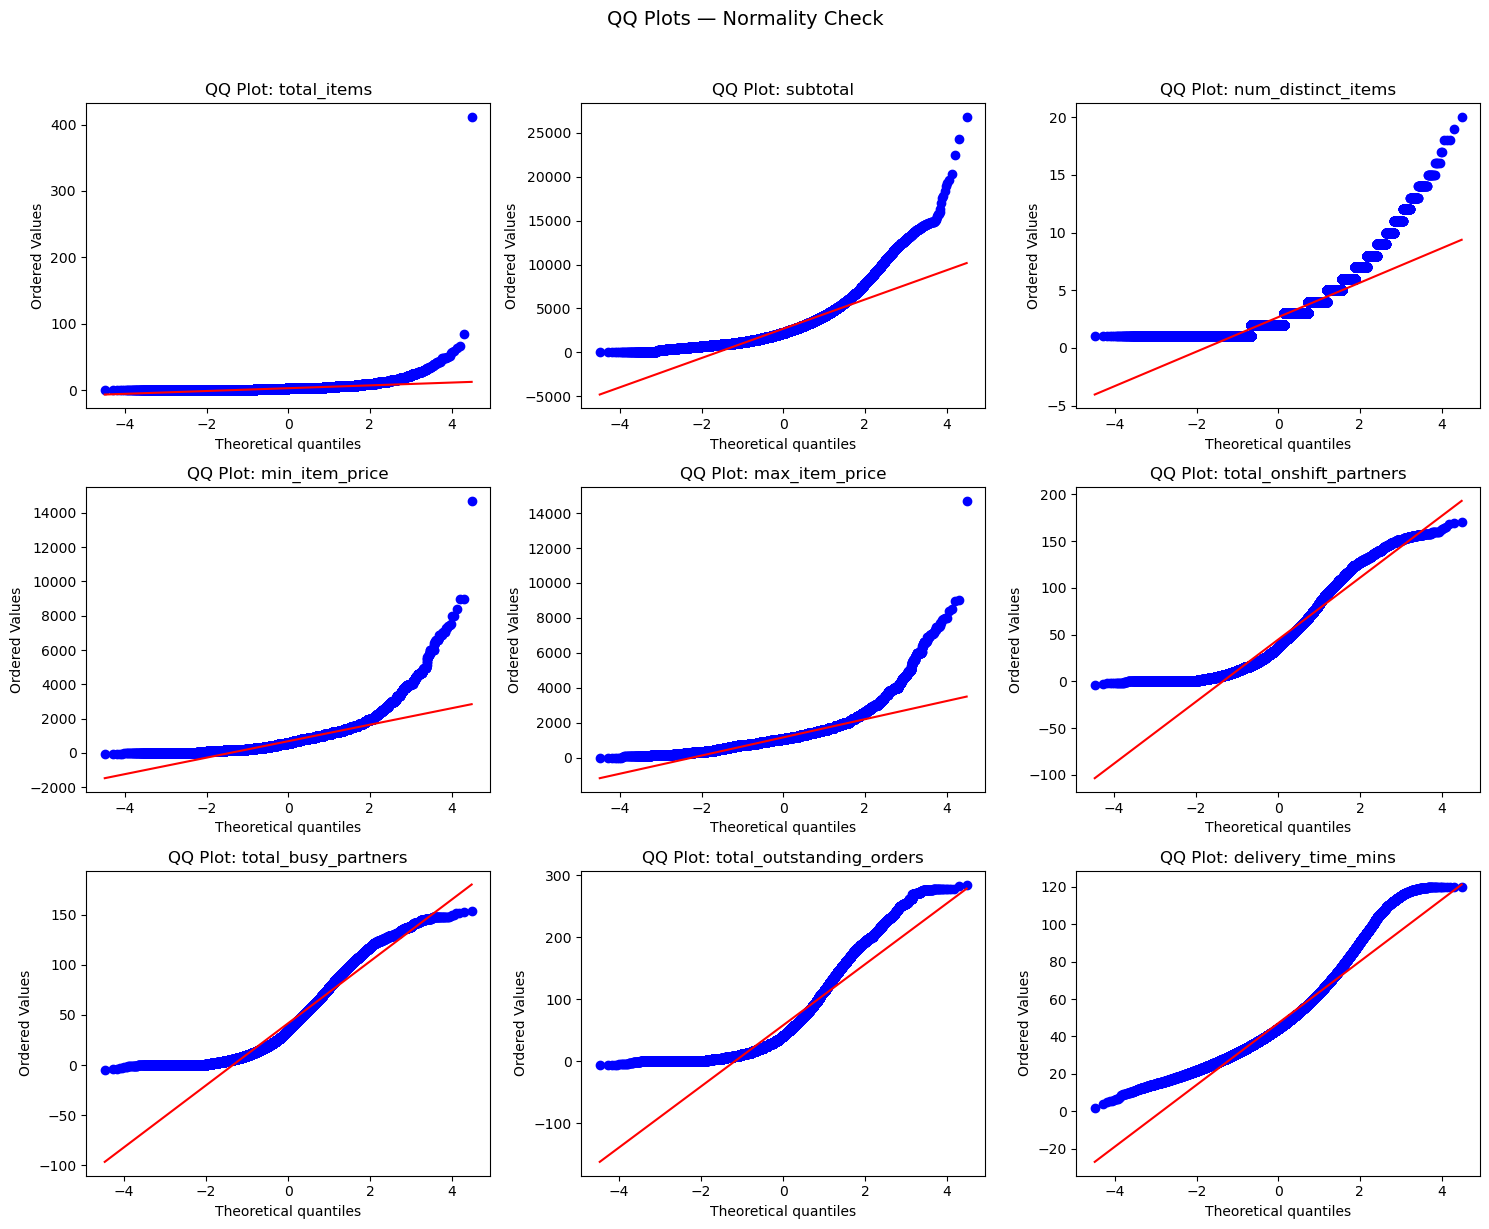

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    stats.probplot(df_clean[col].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'QQ Plot: {col}')
    axes[i].get_lines()[1].set_color('red')

plt.suptitle('QQ Plots — Normality Check', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

#### Reading the QQ plots

QQ plots are one of those tools that look confusing until someone explains them once, then you see them clearly forever.

##### How to Read a QQ Plot — Once and For All

The red diagonal line = **what perfect normality looks like.**
The blue dots = **your actual data.**

Read deviations like this:

**Dots follow the line closely** → normally distributed ✅

**S-shaped curve** → your data has lighter tails than normal (platykurtic) — exactly what you predicted, and you can see this in `total_busy_partners` and `total_onshift_partners`

**Banana/curve bending upward at both ends** → heavy tails, high kurtosis — see `subtotal`, `min_item_price`, `max_item_price`

**Single extreme dot flying off** → one or few massive outliers — look at `total_items`, that lone dot at 400 is screaming at you

---

##### Reading Your Specific Plots

**`total_items`** — Almost flat line then one dot at 400. That single outlier is so extreme it compressed everything else. Kurtosis 2823 visualized.

**`total_onshift_partners` and `total_busy_partners`** — S-shaped, relatively close to diagonal in the middle. Negative kurtosis confirmed visually. These are your cleanest features.

**`subtotal`, `min_item_price`, `max_item_price`** — Heavy curve bending away at the top right. Classic right skew with heavy upper tail. Log transformation will straighten these significantly.

**`delivery_time_mins`** — Pretty close to the diagonal in the middle bulk, slight curve at the top right. Our 120 min cap helped a lot. Log1p will fix the remainder.

### Part 3 — Hypothesis Testing

Now the most powerful part of statistical analysis. This is where you stop saying *"market 1 looks slower"* and start saying *"market 1 is statistically significantly slower."*

#### The Framework — Always the Same 4 Steps

**Step 1:** State the null hypothesis (H₀) — assume no difference exists

**Step 2:** Choose significance level — typically α = 0.05 (5% chance of being wrong)

**Step 3:** Run the test, get p-value

**Step 4:** If p-value < 0.05, reject H₀ — the difference is real, not noise

---

#### We'll Test Three Things We Saw in EDA

1. Is the difference in delivery time across **markets** statistically significant?
2. Is the difference in delivery time across **order protocols** statistically significant?
3. Is **hour of day** actually predictive or just noise?


In [17]:
from scipy.stats import f_oneway, kruskal

# Test 1: Market ID
market_groups = [group['delivery_time_mins'].values 
                 for name, group in df_clean.groupby('market_id')]

f_stat, p_market = f_oneway(*market_groups)
h_stat, p_market_kruskal = kruskal(*market_groups)

print("=== TEST 1: Market ID vs Delivery Time ===")
print(f"ANOVA      — F-statistic: {f_stat:.4f}, p-value: {p_market:.6f}")
print(f"Kruskal-W  — H-statistic: {h_stat:.4f}, p-value: {p_market_kruskal:.6f}")

=== TEST 1: Market ID vs Delivery Time ===
ANOVA      — F-statistic: 365.1017, p-value: 0.000000
Kruskal-W  — H-statistic: 1192.1372, p-value: 0.000000


In [18]:

# Test 2: Order Protocol
protocol_groups = [group['delivery_time_mins'].values 
                   for name, group in df_clean.groupby('order_protocol')]

f_stat2, p_protocol = f_oneway(*protocol_groups)
h_stat2, p_protocol_kruskal = kruskal(*protocol_groups)

print("\n=== TEST 2: Order Protocol vs Delivery Time ===")
print(f"ANOVA      — F-statistic: {f_stat2:.4f}, p-value: {p_protocol:.6f}")
print(f"Kruskal-W  — H-statistic: {h_stat2:.4f}, p-value: {p_protocol_kruskal:.6f}")


=== TEST 2: Order Protocol vs Delivery Time ===
ANOVA      — F-statistic: 342.3237, p-value: 0.000000
Kruskal-W  — H-statistic: 1948.7594, p-value: 0.000000


In [19]:
# Test 3: Hour of day (peak vs off-peak)
df_clean['is_peak'] = df_clean['hour'].isin([11,12,13,14,15,19,20,21]).astype(int)
peak = df_clean[df_clean['is_peak']==1]['delivery_time_mins']
offpeak = df_clean[df_clean['is_peak']==0]['delivery_time_mins']

from scipy.stats import mannwhitneyu
u_stat, p_peak = mannwhitneyu(peak, offpeak, alternative='two-sided')

print("\n=== TEST 3: Peak Hours vs Off-Peak ===")
print(f"Mann-Whitney U — p-value: {p_peak:.6f}")
print(f"Peak avg: {peak.mean():.2f} mins")
print(f"Off-peak avg: {offpeak.mean():.2f} mins")


=== TEST 3: Peak Hours vs Off-Peak ===
Mann-Whitney U — p-value: 0.000000
Peak avg: 43.68 mins
Off-peak avg: 48.00 mins
